In [1]:
%%capture
!pip install -q transformers datasets rouge-score
# !pip install gensim
# !pip install nmslib
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install
!pip install sentence_transformers
!pip install annoy
!pip install nltk
!pip install contractions
#install spacy large language model. (Colab needs to be restarted/)
!python -m spacy download en_core_web_lg


In [2]:
# import tensorflow_datasets as tfds 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re 
import spacy
from tqdm.notebook import tqdm
  
import tensorflow_hub as hub
from tensorflow import keras 
import tensorflow as tf
from IPython.display import Image 
import matplotlib.pyplot as plt


nlp = spacy.load('en_core_web_lg')

In [3]:
data = pd.read_csv("94matched_url_body_casetitles.csv",usecols=["body","case_title_y"],index_col=False)
# data.drop_duplicates(subset="case_title_x", inplace=True)
data = data.rename(columns={"case_title_y" : "case_title","body":"case_description"})
data.drop_duplicates(inplace=True)
data.head()

,case_description,case_title
0,Azure Azure Databricks Azure Azure Databricks ...,DBFS API 2.0
1,Docs Azure Azure Databricks Docs Azure Azure D...,Databricks Runtime 10.4 LTS
4,Docs Azure Azure Databricks Docs Azure Azure D...,Access Azure Data Lake Storage using Azure Act...
7,Azure Azure Databricks Azure Azure Databricks ...,Best practices: pools
8,Docs Azure Azure Databricks Docs Azure Azure D...,Azure Synapse Analytics


In [4]:
import nltk
# import nltk
# # nltk.download('omw-1.4')
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
# from nltk.corpus import wordnet

nltk.download('omw-1.4')

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.corpus import stopwords
stops = stopwords.words('english')
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
warnings.filterwarnings('ignore')

stopwords_eng = stopwords.words('english')

# add datbricks stop words
# stopwords_eng +=["to","the","is","in","and","for","a","databricks","this","not","i","with","it","we","of","on","https","are","have","that","but","please","from","can","you","when","if","-","as","o","be","or","has","customer","see","using","an","time","any",".","our","t","help","hi","was","there","team","am","my","url","at","by","id","what","below","which","need","no","could","some","while","use","new","same","us","s","they","me","also","how","details","after","know","all","so","would","thanks","one","like","start","1","do","2","2022","however","00","up","about","hello","only","will","did","arr","your","true","tried","check","before","due","been","note","other","false","out","more","end","cannot","where","into","then","support","want","why","does","since","happened","were","found","last","details.","m","still","here","these","question","answer","time", "subscription", "subscriptions","didn","successfully","successful","went", "test", "tested","tests", "confirm", "confirmed","along","both","non","through","means","being","asked","ask","able","unable","believe","something","actually","back","identified","jan","feb","mar","apr","may","jun","jul","oct","nov","dec","chennai","kolkata","mumbai","delhi","never","worked","answers","stopped","occurring","issue","earlier","list","monday","onwards","already","exists","getting","error","fail","get","job","prod","utc-05","eastern","canada","additional","questions","problem","begin","00.000z","approximate","ongoing","leave","sun","mon","tue","wed","thu","fri","sat","utc-07","within","requesttypeid","subscriptiontype","location","resourcegroups","providers","utc-06","central","just","ultimately","because","problemstarttime","goes","having","said","its","locality","go","azureproductsubscriptionname","azureproductsubscriptionid","tenant","unifiedenterprise","supportplandisplayname","databricksconsent","grantpermission","hdinsightconsent","sharememorydump","following","during","resourceuri","workspaceid","workspaces","workspace","hence","caused","though","instanceid","getinstanceid","utc","seconds","elapsed","reason","recent","name","likely","most","times","must","specify","e.g","via","doesn","agent_additional_properties_do_not_edit","start","wasn","requestid","serverrequestid","yesterday","morning","needed","phone","contact","person","seamlessly","efficiently","yes","no","given","party","description","now","minutes","minute","instance","anything","feels","done","such","today","others","came","very","such","mins","avoid","http","https","fix","day","again","had","checked","check","even","sometimes","facing","asking","cause","necessary","steps","resolve","every","comes","under","keeps","showing","perfectly","personal","between","consent","insight","turned","off","email","hostedcontainer","hostprivateip","containerip","clusterid","resources","instantiatedresources","memorymb","ecus","cgroupshares","instancetype","metadata","containermetadata","happen","consider","org","sure","follow-up","jobname","bricks","own","involved","gets","directly","two","recently","happens","solve","issues","queries","possible","present","exist","path","call","deco", "raise","spark","pyspark","traceback","java.lang.thread.run"];

def remove_stops(query):
    new_word = []
    for word in query.split():
        if word in stopwords_eng or word.isdigit():
            pass
        else:
            new_word.append(word.strip().lower())
    
    return ' '.join(new_word)


from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()


def lemmatize(query):
    new_word = []
    for word in query.split():
        new_word.append(wordnet_lemmatizer.lemmatize(word, pos="v").strip())

    return ' '.join(new_word)


# import these modules
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize,sent_tokenize
 
ps = PorterStemmer()

def stem_(query):
    new_word = []
    for word in query.split():
        new_word.append(ps.stem(word).strip())

    return ' '.join(new_word)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
# data2["clean case"] = data2["case_joined"].apply(remove_stops)
# data2["clean post"] = data2["post_joined"].apply(remove_stops)
data["case_title"] = data["case_title"].apply(lemmatize)
data["case_description"] = data["case_description"].apply(lemmatize)
# data2["clean case"] = data2["clean case"].apply(stem_)
# data2["clean post"] = data2["clean post"].apply(stem_)

In [6]:
def clean(query):
  # query = re.sub(r'[^\w]', ' ', query)
  query = re.sub("[^a-zA-Z :\.]", "",query)                         # remove all symbols except .
  # # query = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", query)
  
  # # keep only nouns and proper nouns
  new_word = []
  for word in nltk.word_tokenize(query):
  #   tagged = nltk.pos_tag([word])
  #   tag = tagged[0][1]
  #   # if tag == "NN" or tag == "NNP":
  #   if tag == "NN":
      new_word.append(word.strip().lower())
  
  return ' '.join(new_word)
  # return query

In [7]:
data["case_title"] = data["case_title"].apply(clean)
data["case_description"] = data["case_description"].apply(clean)

In [8]:
data.reset_index(inplace=True,drop=True)

## Export Data Subset for Reuse 

- We will write the test and train datasets to disc to avoid new downloads each time we reuse them in subsequent notebooks.

In [9]:
import os

In [10]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(data, test_size=0.2, random_state=35)
train.reset_index(drop=True, inplace=True)
train.head(2)

train.shape, val.shape

((44, 2), (12, 2))

In [11]:
os.makedirs("data/", exist_ok=True) 
os.makedirs("data/test", exist_ok=True) 
os.makedirs("data/train", exist_ok=True) 

val.to_json("data/test/test.json")
train.to_json("data/train/train.json")


## Data Preprocessing - Extacting Sentences with Spacy


For each article, we extract sentences with Spacy
- construct `sentence` dictionary and `document` dictionary
- Note the `min_sent_length` hyper parameter - we only add sentences that have > 14 characters. This can be modified based on the expected sentence lengths at test time.

In [12]:

def get_dicts(df, folder="test"):   
  sents_dict = {}
  doc_dict = { i: {"article": df["case_description"][i], "highlight": df["case_title"][i]} for i in df.index }
  raw_docs = [ doc_dict[k]["article"] for k in doc_dict.keys()]

  doc_sents = {}
  sents_list = []
  raw_sents = [] 
  i = 0
  min_sent_length = 2
  for k in tqdm(doc_dict.keys()):
    article = doc_dict[k]["article"]  
    highlight = doc_dict[k]["highlight"] 
    sents = nlp(article).sents
    doc_sent_ids = [] 
    for sent in sents:
      if (len(sent)) > min_sent_length:
        sents_dict[i] = {"docid":k, "text": str(sent)} 
        sents_list.append({"sentid":i, "docid":k, "text": str(sent) }) 
        raw_sents.append(str(sent))
        i += 1  
         
  return doc_dict, sents_list

test_doc_dict, test_sents_list = get_dicts(val)
train_doc_dict, train_sents_list = get_dicts(train)  

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

## Get Labels and Balanced Dataset

- Get labels for each sentence
- The dataset is unbalanced (most sentences are unlikely to be in the summary). 
- Construct new dataset of examples that balances positive examples with negative examples. (e.g. equal, 2x).

In [13]:
from rouge_score import rouge_scorer 
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

def get_rougue_score(text, highlights, metric="rougeL"):
  max_score = 0
  for h_text in highlights:
    score =  scorer.score(text, h_text)[metric].fmeasure
    # print(score, text, "\n \t" , h_text)
    if score > max_score:
      max_score = score 
  return max_score 


def get_label(sent, doc_dict,  score_threshold = 0.50):
  sent_id, doc_id, sentence = sent["sentid"], sent["docid"], sent["text"]  
  highlights = doc_dict[doc_id]["highlight"].split("\n")
  doc = doc_dict[doc_id]["article"]

  label_score = get_rougue_score(sentence, highlights) 
  # Normalize label to 0/1 based on rogue score threshold
  label_score = 0 if label_score < score_threshold else 1 
  return (sentence, doc, label_score)
  
def sub_sample(sents_batch, doc_dict, neg_multiplier=2):
  # get labels 
  vals = [get_label(x, doc_dict)  for x in sents_batch] 

  # construct arrays of sentences, corresponding documents and labels  
  sents, docs, y = [], [], [] 
  for row in vals:
    sents.append(row[0])
    docs.append(row[1])
    y.append(row[2])
   

  # get balanced number of positive and negative
  sub_df = pd.DataFrame.from_dict({"sents":sents, "docs":docs, "y":y}) 
  pos_df = sub_df[sub_df.y == 1]
  neg_df = sub_df[sub_df.y == 0]

  print("Negative sample size:", len(neg_df))
  print("Positive sample size:", len(pos_df))

  sub_neg_df = neg_df.sample(len(pos_df)*neg_multiplier) 
  balanced_df = pos_df.append(sub_neg_df)
  
  return balanced_df



In [14]:
train_bdf = sub_sample(train_sents_list, train_doc_dict)
test_bdf = sub_sample(test_sents_list, test_doc_dict)
# train_bdf.to_json("data/train_bdf.json")
# test_bdf.to_json("data/test_bdf.json")

# !gsutil cp -r data $sum_dir
train_df_1 =pd.DataFrame(train_bdf)
test_df_1 =pd.DataFrame(test_bdf)

Negative sample size: 4364
Positive sample size: 83
Negative sample size: 1085
Positive sample size: 5


In [16]:
train_df_1.to_json('/content/data/train_bdf.json')
# train_df_1.to_json('new.json')
test_df_1.to_json('/content/data/test_bdf.json')
# !gsutil cp -r data $sum_dir


#Extractive Summarization - Pytorch

In [17]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
 
import pandas as pd 
import transformers
from torch.utils.data import Dataset, DataLoader 


from transformers import AutoTokenizer, AutoModel
sentenc_model_name = "sentence-transformers/paraphrase-MiniLM-L3-v2"
tokenizer = AutoTokenizer.from_pretrained(sentenc_model_name)

In [18]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 512
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
EPOCHS = 1
LEARNING_RATE = 1e-05 
# load dataframes containining preprocessed samples from CNN/Dailymail Dataset
train_df = pd.read_json("/content/data/train_bdf.json")
test_df = pd.read_json("/content/data/test_bdf.json") 
print( "Train, test shape", train_df.shape, test_df.shape)


Train, test shape (249, 3) (15, 3)


#Create a Data Loader Class
Create a dataloader class that yields sentences and documentss and labels.

In [19]:
# Create a Data Loader Class
class DatabricksData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        sentence = str(self.data.iloc[index].sents)
        sentence = " ".join(sentence.split())

        document = str(self.data.iloc[index].docs)
        document = " ".join(document.split())

        inputs = self.tokenizer.batch_encode_plus(
            [sentence, document], 
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'sent_ids': torch.tensor(ids[0], dtype=torch.long),
            'doc_ids': torch.tensor(ids[1], dtype=torch.long),
            'sent_mask': torch.tensor(mask[0], dtype=torch.long),
            'doc_mask': torch.tensor(mask[1], dtype=torch.long),
            'targets': torch.tensor([self.data.iloc[index].y], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len



training_set = DatabricksData(train_df, tokenizer, MAX_LEN)
testing_set = DatabricksData(test_df, tokenizer, MAX_LEN)

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

#Build Model
Build model based on sentence Bert pretrained models.

In [20]:
# get mean pooling for sentence bert models 
# ref https://www.sbert.net/examples/applications/computing-embeddings/README.html#sentence-embeddings-with-transformers
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask


# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 
# Note that different sentence transformer models may have different in_feature sizes
class SentenceBertClass(torch.nn.Module):
    def __init__(self, model_name="sentence-transformers/paraphrase-MiniLM-L3-v2", in_features=384):
        super(SentenceBertClass, self).__init__()
        self.l1 = AutoModel.from_pretrained(model_name)
        self.pre_classifier = torch.nn.Linear(in_features*3, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 1)
        self.classifierSigmoid = torch.nn.Sigmoid()

    def forward(self, sent_ids, doc_ids, sent_mask, doc_mask):

        sent_output = self.l1(input_ids=sent_ids, attention_mask=sent_mask) 
        sentence_embeddings = mean_pooling(sent_output, sent_mask) 

        doc_output = self.l1(input_ids=doc_ids, attention_mask=doc_mask) 
        doc_embeddings = mean_pooling(doc_output, doc_mask)

        # elementwise product of sentence embs and doc embs
        combined_features = sentence_embeddings * doc_embeddings  

        # Concatenate input features and their elementwise product
        concat_features = torch.cat((sentence_embeddings, doc_embeddings, combined_features), dim=1)   
        
        pooler = self.pre_classifier(concat_features) 
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        output = self.classifierSigmoid(output) 

        return output

In [21]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

model = SentenceBertClass(model_name=sentenc_model_name)
model.to(device);

loss_function = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [22]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model
print_n_steps = 1000
EPOCHS = 3 
acc_step_holder, loss_step_holder = [], []


def train(epoch):    
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        sent_ids = data['sent_ids'].to(device, dtype = torch.long)
        doc_ids = data['doc_ids'].to(device, dtype = torch.long)
        sent_mask = data['sent_mask'].to(device, dtype = torch.long)
        doc_mask = data['doc_mask'].to(device, dtype = torch.long) 
        targets = data['targets'].to(device, dtype = torch.float)  

        outputs = model(sent_ids, doc_ids, sent_mask, doc_mask) 
        loss = loss_function(outputs, targets)
        tr_loss += loss.item() 
        n_correct += torch.count_nonzero(targets == (outputs > 0.5)).item()

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%print_n_steps==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(str(_* train_params["batch_size"]) + "/" + str(len(train_df)) + " - Steps. Acc ->", accu_step, "Loss ->", loss_step)
            acc_step_holder.append(accu_step), loss_step_holder.append(loss_step)
        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return

In [23]:
for epoch in range(EPOCHS):
    train(epoch)

0it [00:00, ?it/s]

0/249 - Steps. Acc -> 0.0 Loss -> 0.7059258818626404
The Total Accuracy for Epoch 0: 83.93574297188755
Training Loss Epoch: 0.6393225306556338
Training Accuracy Epoch: 83.93574297188755


0it [00:00, ?it/s]

0/249 - Steps. Acc -> 100.0 Loss -> 0.5138416290283203
The Total Accuracy for Epoch 1: 91.16465863453816
Training Loss Epoch: 0.4615189359774665
Training Accuracy Epoch: 91.16465863453816


0it [00:00, ?it/s]

0/249 - Steps. Acc -> 100.0 Loss -> 0.2161167412996292
The Total Accuracy for Epoch 2: 89.95983935742971
Training Loss Epoch: 0.31525471652784043
Training Accuracy Epoch: 89.95983935742971


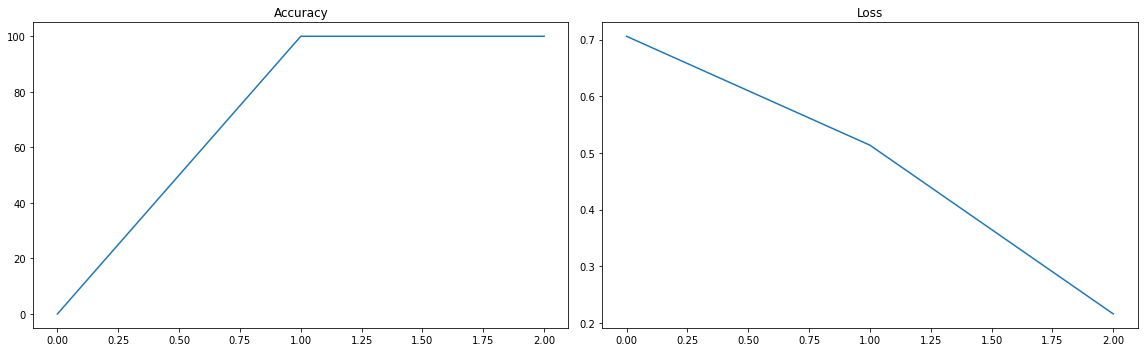

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
ax1.plot(acc_step_holder, label="Accuracy")
ax2.plot(loss_step_holder, label="Loss")
ax1.title.set_text("Accuracy")
ax2.title.set_text("Loss")
fig.tight_layout()
plt.show()

In [25]:
import os 

os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "models/minilm_bal_exsum.pth")
!gsutil cp -r models $sum_dir

CommandException: Wrong number of arguments for "cp" command.


#Extractive Summarization Inference
In this notebook we will

Load a pretrained Pytorch model for extractive summarization
Perform inference and visualize sentence scores.
Build a simple pipleline for abstractive summarization using HuggingFace transformers

In [26]:
# get mean pooling for sentence bert models 
# ref https://www.sbert.net/examples/applications/computing-embeddings/README.html#sentence-embeddings-with-transformers
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask


# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class SentenceBertClass(torch.nn.Module):
    def __init__(self, model_name="sentence-transformers/paraphrase-MiniLM-L3-v2"):
        super(SentenceBertClass, self).__init__()
        self.l1 = AutoModel.from_pretrained(model_name)
        self.pre_classifier = torch.nn.Linear(384*3, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 1)
        self.classifierSigmoid = torch.nn.Sigmoid()

    def forward(self, sent_ids, doc_ids, sent_mask, doc_mask):

        sent_output = self.l1(input_ids=sent_ids, attention_mask=sent_mask) 
        sentence_embeddings = mean_pooling(sent_output, sent_mask) 

        doc_output = self.l1(input_ids=doc_ids, attention_mask=doc_mask) 
        doc_embeddings = mean_pooling(doc_output, doc_mask)

        # elementwise product of sentence embs and doc embs
        combined_features = sentence_embeddings * doc_embeddings  

        # get concat of both features and elementwise product
        feat_cat = torch.cat((sentence_embeddings, doc_embeddings, combined_features), dim=1)  
        
        pooler = self.pre_classifier(feat_cat) 
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        output = self.classifierSigmoid(output) 

        return output

In [27]:
#model path .. modify to location of trained model file 
model_path = "/content/models/minilm_bal_exsum.pth"

In [29]:
from torch import cuda
# device = 'cuda' if cuda.is_available() else 'cpu'
device = torch.device('cpu')

extractive_model = SentenceBertClass() 
extractive_model.load_state_dict(torch.load(model_path, map_location= device ))
extractive_model.eval();

#Extractive Summarization Inference

In [30]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-MiniLM-L3-v2')

# tokenize text as required by BERT based models
def get_tokens(text, tokenizer):
  inputs = tokenizer.batch_encode_plus(
            text, 
            add_special_tokens=True,
            max_length=512,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
  ids = inputs['input_ids']
  mask = inputs['attention_mask']
  return ids, mask

In [31]:
# get predictions given some an array of sentences and their corresponding documents
def predict(model,sents, doc):
  sent_id, sent_mask = get_tokens(sents,tokenizer)
  sent_id, sent_mask = torch.tensor(sent_id, dtype=torch.long),torch.tensor(sent_mask, dtype=torch.long)
 
  doc_id, doc_mask = get_tokens([doc],tokenizer)
  doc_id, doc_mask = doc_id * len(sents), doc_mask* len(sents)
  doc_id, doc_mask = torch.tensor(doc_id, dtype=torch.long),torch.tensor(doc_mask, dtype=torch.long)

  preds = model(sent_id, doc_id, sent_mask, doc_mask)
  return preds

In [32]:
def summarize(doc, model, min_sentence_length=14, top_k=3, batch_size=3):
  doc = doc.replace("\n","")
  doc_sentences = []
  for sent in nlp(doc).sents:
    if len(sent) > min_sentence_length: 
      doc_sentences.append(str(sent))
  
  doc_id, doc_mask = get_tokens([doc],tokenizer)
  doc_id, doc_mask = doc_id * batch_size, doc_mask* batch_size
  doc_id, doc_mask = torch.tensor(doc_id, dtype=torch.long),torch.tensor(doc_mask, dtype=torch.long)

  scores = [] 
  # run predictions using some batch size
  for i in tqdm(range(int(len(doc_sentences) / batch_size) + 1)):
    batch_start = i*batch_size  
    batch_end = (i+1) * batch_size if (i+1) * batch_size < len(doc) else len(doc)-1
    batch = doc_sentences[batch_start: batch_end]
    if batch:
      preds = predict(model, batch, doc) 
      scores = scores + preds.tolist() 
 
  sent_pred_list = [{"sentence": doc_sentences[i], "score": scores[i][0], "index":i} for i in range(len(doc_sentences))]
  sorted_sentences = sorted(sent_pred_list, key=lambda k: k['score'], reverse=True) 

  sorted_result = sorted_sentences[:top_k] 
  sorted_result = sorted(sorted_result, key=lambda k: k['index']) 
  
  summary = [ x["sentence"] for x in sorted_result]
  summary = " ".join(summary)

  return summary, scores, doc_sentences

In [35]:
article = data['case_description'][1]

In [39]:
summary, scores, sentences = summarize(article, extractive_model, min_sentence_length=14, top_k=3, batch_size=4)
summary

  0%|          | 0/10 [00:00<?, ?it/s]

'docs azure azure databricks docs azure azure databricks read in english save table of content read in english save feedback edit twitter linkedin facebook email table of content databricks runtime . identity columns support in delta table be now generally available delta lake now support identity columns . globals .. glue .. googledrive .. googlesheets .. gower .. graphics .. grdevices .. grid ..'

#Visualize Scores Assigned to Each Sentence
A visualization of the scores assigned by the model can help us "make sense" of model behaviour.

is the model weighting each sentence equally or focusing on some sentences? (ideally, we want to see good variation).

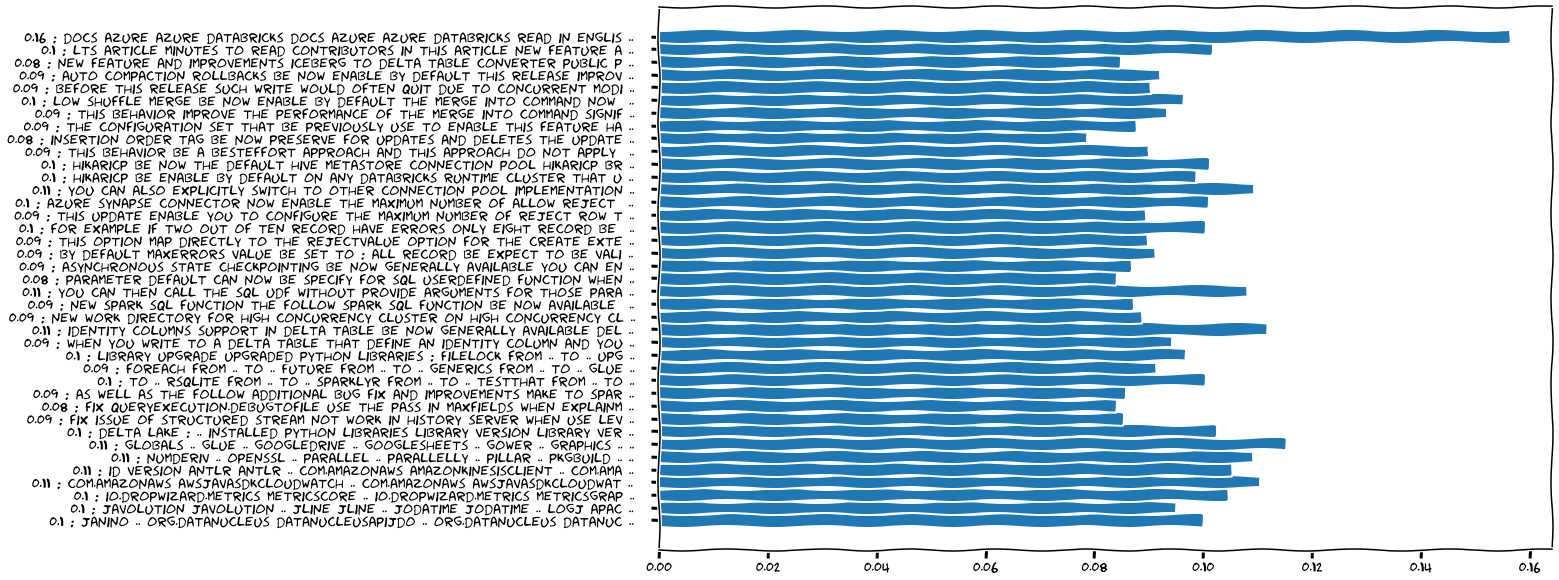

In [37]:
sent_lenth = 70
score_vals = ([x[0] for x in scores] ) 
sub_sents = [ str(round(score_vals[i],2)) + " : " + sentences[i][:sent_lenth] + " ..  " for i in range(len(sentences))] 
with plt.xkcd():
    plt.figure(figsize=(16,10));
    plt.barh(sub_sents[::-1], score_vals[::-1]);

#Abstractive Summarization with HF for Comparison

In [55]:
import urllib.request

import json

def save_json(data, file_path): 
  with open(file_path, 'w', encoding='utf-8') as f:
      json.dump(data, f, ensure_ascii=False, indent=4)

In [40]:
from transformers import pipeline
from tqdm.notebook import tqdm
ab_summarizer = pipeline("summarization", model="t5-base")
import re


In [41]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

abs_model = AutoModelForSeq2SeqLM.from_pretrained("t5-base")
abs_tokenizer = AutoTokenizer.from_pretrained("t5-base")


In [49]:
def abstractive_summarize(doc,  max_length=250, min_length=50, batch_size=2):
  all_sum=[]
  # batched prediction
  for i in tqdm(range(int(len(doc) / batch_size) + 1)): 
    batch_start = i*batch_size  
    batch_end = (i+1) * batch_size if (i+1) * batch_size < len(doc) else len(doc)
    batch = ["summarize: " + x for x in doc[batch_start: batch_end]]   
    if (batch):
      inputs = abs_tokenizer.batch_encode_plus( batch, return_tensors="pt", max_length=512, truncation=True, padding=True) 
      outputs = abs_model.generate(inputs["input_ids"], max_length=max_length, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
      output = [re.sub(r'<([^>]*)>', "", abs_tokenizer.decode(x))  for x in outputs.tolist()]  
      all_sum = all_sum + output 
  return all_sum

In [50]:
article_contents = data['case_description'].to_list()

In [51]:
ab_summary = abstractive_summarize(article_contents)

  0%|          | 0/29 [00:00<?, ?it/s]

In [52]:
(ab_summary)

[' azure azure databricks read in english save table of content read in english save. limitations add block close create delete get status list mkdirs move put read data structure the dbfs api be a databricks api that make it simple to interact with various data source without have to include your credentials every time you read a file.',
 ' docs azure azure databricks read in english save table of content read in english save. lts article minutes to read contributors in this article new feature and improvements library upgrade apache spark maintenance update system environment the follow release note provide information about databricks runtime.',
 ' azure databricks do not support credential passthrough for high concurrency clusters. azure blob storage do not support credential passthrough for highconcurrency clusters. azure blob storage do not support credential passthrough for highconcurrency clusters.',
 ' azure azure databricks provide an efficient and costeffective way to manage

In [53]:
ex_summary =  [summarize(x, extractive_model)[0] for x in article_contents ]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [54]:
ex_summary

['azure azure databricks azure azure databricks read in english save table of content read in english save feedback edit twitter linkedin facebook email table of content dbfs api . for an easy to use command line client of the dbfs api see databricks cli . note to ensure high quality of service under heavy load azure databricks be now enforce api rate limit for dbfs api calls .',
 'docs azure azure databricks docs azure azure databricks read in english save table of content read in english save feedback edit twitter linkedin facebook email table of content databricks runtime . identity columns support in delta table be now generally available delta lake now support identity columns . globals .. glue .. googledrive .. googlesheets .. gower .. graphics .. grdevices .. grid ..',
 'azure data lake storage credential passthrough be support with azure data lake storage gen and gen only . an azure databricks administrator need to ensure that users have the correct roles for example storage bl

In [56]:
all_sum = [ {"title": data['case_title'][i], "content": data['case_description'][i], "abstractive": ab_summary[i], "extractive": ex_summary[i]} for i in range(len(article_contents))]
save_json(all_sum,"samples.json")


In [57]:
df = pd.DataFrame.from_dict(all_sum)
df


,title,content,abstractive,extractive
0,dbfs api .,azure azure databricks azure azure databricks ...,azure azure databricks read in english save t...,azure azure databricks azure azure databricks ...
1,databricks runtime . lts,docs azure azure databricks docs azure azure d...,docs azure azure databricks read in english s...,docs azure azure databricks docs azure azure d...
2,access azure data lake storage use azure activ...,docs azure azure databricks docs azure azure d...,azure databricks do not support credential pa...,azure data lake storage credential passthrough...
3,best practices : pool,azure azure databricks azure azure databricks ...,azure azure databricks provide an efficient a...,the azure databricks platform provide an effic...
4,azure synapse analytics,docs azure azure databricks docs azure azure d...,azure synapse analytics leverages massively p...,to verify that the ssl encryption be enabled y...
5,concurrency control,azure azure databricks azure azure databricks ...,azure azure databricks azure azure databricks...,readers continue to see a consistent snapshot ...
6,scim api . users,docs azure azure databricks docs azure azure d...,docs azure azure databricks read in english s...,docs azure azure databricks docs azure azure d...
7,scim api . groups,azure azure databricks azure azure databricks ...,azure azure databricks azure azure databricks...,azure azure databricks azure azure databricks ...
8,external apache hive metastore,azure azure databricks azure azure databricks ...,azure azure databricks read in english save t...,the follow table summarize which hive metastor...
9,manage cluster,docs azure azure databricks docs azure azure d...,docs azure azure databricks docs azure azure ...,events be store for days which be comparable t...


In [58]:
df.to_csv("summarization.csv",index=False)